In [1]:
%matplotlib inline
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import datetime
import matplotlib
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [2]:
class RSI(bt.Strategy):
    
    params = (('oversold_limit', 30), ('overbought_limit', 70),)
    
    def log(self, text, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print("%s %s" %(dt.isoformat(), text))
        
    def __init__(self):
        self.rsi = btind.RSI(self.data)
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
        # Reset
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    def next(self):
        if self.order:
            return
        if not self.position:
            # rsi in oversold region
            if self.rsi< self.p.oversold_limit:
                self.log("Buy (Creating a long position) at %s" %self.data.close[0])
                self.order = self.buy()
            # rsi in overbought region
            if self.rsi> self.p.overbought_limit:
                self.log("Sell (Creating a short position) at %s" %self.data.close[0])
                self.order = self.sell()
        else:
             # if it is a long position check for selling opportunity
            if self.position.size>0 and self.rsi > self.p.overbought_limit:
                self.log("Closing the long position at %s" %self.data.close[0])
                self.order = self.close()
            # else if it is short position check for buying opportunity
            if self.position.size<0 and self.rsi < self.p.oversold_limit:
                self.log("Closing the short postion at %s" %self.data.close[0])
                self.order = self.close()

In [3]:
cerebro = bt.Cerebro()
data = btfeeds.YahooFinanceCSVData(
        dataname = 'orcl-1995-2014.txt',
        fromdate=datetime.datetime(2004, 1, 1),
        todate=datetime.datetime(2008, 12, 31),
        reverse=False
    )

In [4]:
cerebro.adddata(data)
cerebro.addstrategy(RSI)
cerebro.broker.setcash(100000.0)  
cerebro.broker.setcommission(commission=0.01)
start_portfolio_value = cerebro.broker.getvalue()

In [5]:
cerebro.run()
end_portfolio_value = cerebro.broker.getvalue()
print("Starting portfolio value: %s \nEnding portfolio value: %s \nProfit: %s" \
          %(start_portfolio_value,end_portfolio_value,end_portfolio_value-start_portfolio_value))

2004-01-23 Sell (Creating a short position) at 12.93
2004-01-26 SELL EXECUTED, Price: 12.86, Cost: -12.86, Comm 0.13
2004-03-12 Closing the short postion at 10.73
2004-03-15 BUY EXECUTED, Price: 10.70, Cost: -12.86, Comm 0.11
2004-03-15 OPERATION PROFIT, GROSS 2.16, NET 1.92
2004-03-15 Buy (Creating a long position) at 10.37
2004-03-16 BUY EXECUTED, Price: 10.49, Cost: 10.49, Comm 0.10
2004-10-05 Closing the long position at 10.86
2004-10-06 SELL EXECUTED, Price: 10.80, Cost: 10.49, Comm 0.11
2004-10-06 OPERATION PROFIT, GROSS 0.31, NET 0.10
2004-10-06 Sell (Creating a short position) at 10.89
2004-10-07 SELL EXECUTED, Price: 10.86, Cost: -10.86, Comm 0.11
2005-04-15 Closing the short postion at 10.41
2005-04-18 BUY EXECUTED, Price: 10.42, Cost: -10.86, Comm 0.10
2005-04-18 OPERATION PROFIT, GROSS 0.44, NET 0.23
2005-06-29 Sell (Creating a short position) at 12.07
2005-06-30 SELL EXECUTED, Price: 12.06, Cost: -12.06, Comm 0.12
2005-09-28 Closing the short postion at 10.84
2005-09-29 BU

<IPython.core.display.Javascript object>


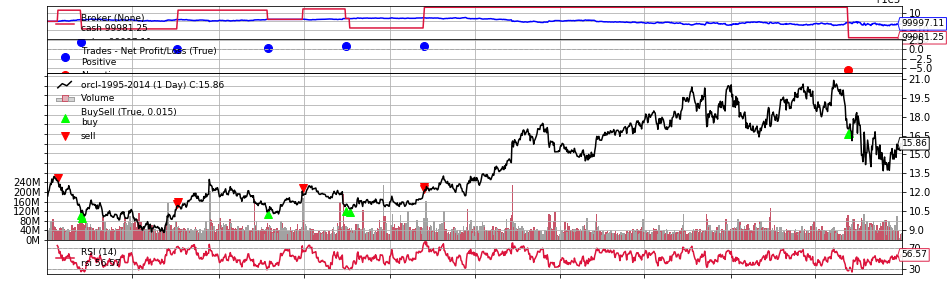

[[<Figure size 432x288 with 5 Axes>]]

In [6]:
cerebro.plot()